In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install Augmentor # 이미지 데이터가 추가적으로 필요한 파일에 대해 Augmntation을 진행해 줄 모듈

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random as rd
import Augmentor
import shutil

# 중복 / 사진 데이터 제거 후 남은 이미지 경로 담은 파일 불러오기

In [ ]:
path_xlsx = "/content/drive/MyDrive/Datarhythm/final_path.xlsx"
df = pd.read_excel(path_xlsx)

In [ ]:
df_list = np.array(df.values.tolist())
df_list[:,1]

array(['/content/drive/MyDrive/commit_folder/hs_dccproject/dataset/L2_12/yvwlldrwlslmwdrrsgec.jpg',
       '/content/drive/MyDrive/commit_folder/hs_dccproject/dataset/L2_12/rfhvojsxykqiifsppkqn.jpg',
       '/content/drive/MyDrive/commit_folder/hs_dccproject/dataset/L2_12/wwykiohhphmlxnfuhqhn.jpg',
       ..., 'nan', 'nan', 'nan'], dtype='<U89')

# 같은 라벨 이미지끼리 모인 이차원 리스트로 + nan 처리 된 부분 없애기

In [ ]:
final = []

for i in range(len(df_list[0])):
  nan_i = np.where(df_list[:,i] == 'nan')
  if len(nan_i[0]) > 0:
    first_nan = nan_i[0][0]
    final.append(df_list[:,i][:first_nan])
  else: final.append(df_list[:,i])

final[1][:5]

array(['/content/drive/MyDrive/commit_folder/hs_dccproject/dataset/L2_12/yvwlldrwlslmwdrrsgec.jpg',
       '/content/drive/MyDrive/commit_folder/hs_dccproject/dataset/L2_12/rfhvojsxykqiifsppkqn.jpg',
       '/content/drive/MyDrive/commit_folder/hs_dccproject/dataset/L2_12/wwykiohhphmlxnfuhqhn.jpg',
       '/content/drive/MyDrive/commit_folder/hs_dccproject/dataset/L2_12/kccbsoehoryvgwkblpgn.jpg',
       '/content/drive/MyDrive/commit_folder/hs_dccproject/dataset/L2_12/yruygnevhxewampcmehe.jpg'],
      dtype='<U89')

# 내 드라이브에 맞게 경로 수정

In [ ]:
root = "/content/drive/MyDrive/Datarhythm/dataset/"

for i in range(len(final)):
  for j in range(len(final[i])):
    split_p = final[i][j].split('/')
    final[i][j] = root + split_p[7] + '/' + split_p[8]

final[0]

array(['/content/drive/MyDrive/Datarhythm/dataset/L2_10/oqfadnuqsmolzmxwfycm.jpg',
       '/content/drive/MyDrive/Datarhythm/dataset/L2_10/pwehgcayutliqfvyvxcm.jpg',
       '/content/drive/MyDrive/Datarhythm/dataset/L2_10/cvleystsurkczhmvnrmt.jpg',
       ...,
       '/content/drive/MyDrive/Datarhythm/dataset/L2_10/paxpbdkbvoqxhdxwedpw.jpg',
       '/content/drive/MyDrive/Datarhythm/dataset/L2_10/enraiajslpvuvcpdwhce.jpg',
       '/content/drive/MyDrive/Datarhythm/dataset/L2_10/wweggkosnfiqvyseukfa.jpg'],
      dtype='<U89')

# 라벨, 이미지 개수

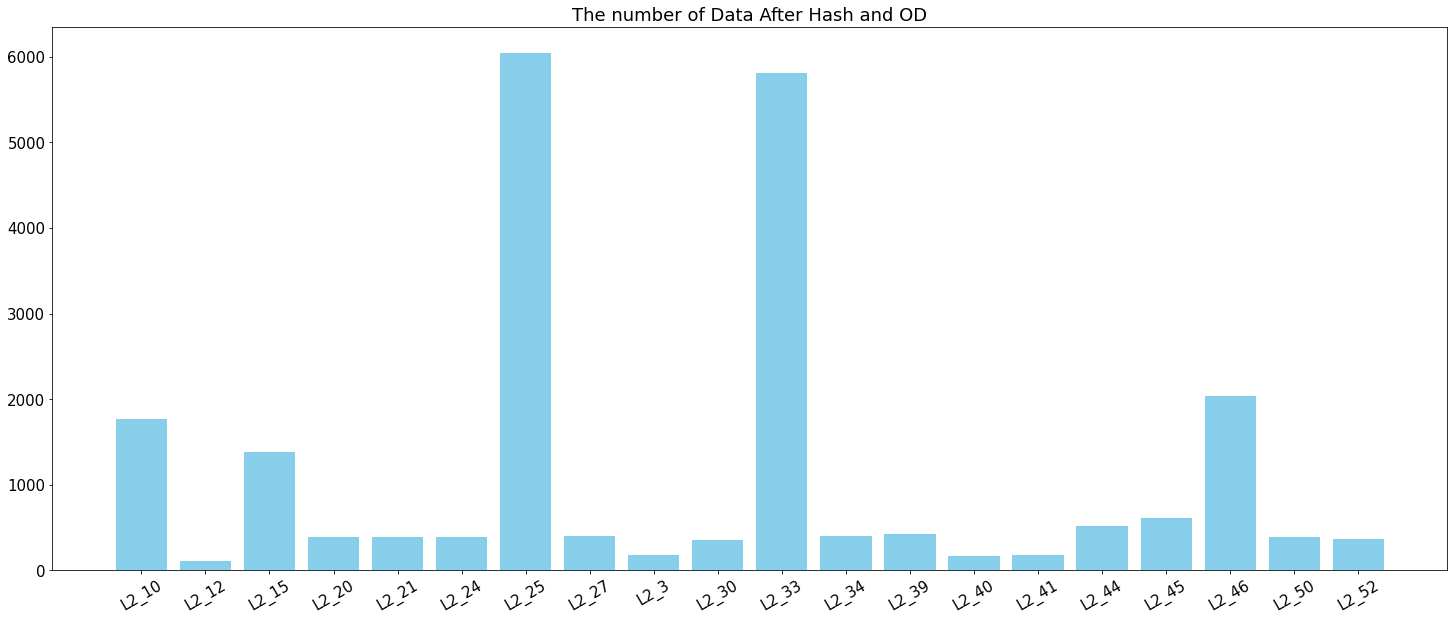

In [ ]:
n_images = []
for f in final:
  n_images.append(len(f))

x = np.arange(20)
label_list = os.listdir(root)

values = n_images

plt.rcParams['font.size'] = 15
plt.figure(figsize=(25,10))

plt.bar(x, values, color='skyblue')
plt.xticks(x, label_list,rotation=30)
plt.title('The number of Data After Hash and OD')
plt.show()

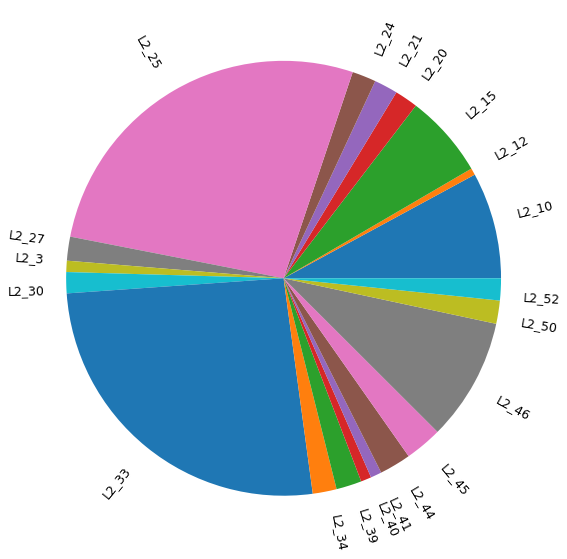

In [ ]:
ratio = []
for i in range(len(n_images)):
  ratio.append(n_images[i] / sum(n_images) * 100)

plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = 12.5
plt.pie(ratio, labels=label_list ,rotatelabels=True)
plt.show()

## 각 라벨 별로 통일될 이미지 개수
### 이미지 개수 약 6000 정도를 가지는 라벨은 무시하고, 그 외 라벨들의 파일 개수평균으로 정했다가, Classification을 진행하는 과정에서 오버피팅을 줄이고자 조금 더 큰 800으로 결정함

In [ ]:
std = 800

# 임밸런스 해결

In [ ]:
# 기준 값 보다 많은 데이터를 가진 라벨에 대해 이미지 개수를 줄이는 함수
# (랜덤으로 중복 없이 인덱스 추출)
def random_eliminate(size, target):
  lst = []
  for _ in range(std):
    num = rd.randint(0,size)
    while num in lst:
      num = rd.randint(0,size)
    lst.append(num)

  new_target = [target[i] for i in lst]
  return new_target

In [ ]:
# 기준 값보다 적은 이미지를 가진 라벨에 대해 이미지 개수를 늘려주는 함수 (augmentation)
def augmentation(path, n):
  # 기존 데이터에 확률적으로 뒤집기, 왜곡, 회전 등의 효과를 적용해 중복 없이 새로운 데이터 생성
  p = Augmentor.Pipeline(path)
  p.flip_left_right(probability=1) # 옆으로 뒤집기 (필수)
  p.flip_top_bottom(probability=0.6) # 위아래로 뒤집기
  p.random_distortion(probability=0.8, grid_width=4, grid_height=4, magnitude=8) # 왜곡
  p.rotate(0.8, max_left_rotation=5, max_right_rotation=5) # 회전
  p.rotate90(probability=0.5) # 90도 회전
  p.rotate270(probability=0.5) # 270도 회전

  p.sample(n) # 위의 파이프 라인을 따라 새로운 이미지 n개 만들기

  # 새로운 파일에 복사
  new_image_path = path + '/output'
  label = path.split('/')[-1]
  dir = root2 + label
  for f in os.listdir(new_image_path):
    shutil.copyfile(new_image_path + '/' +f, dir + '/' +f)

In [ ]:
root2 = '/content/drive/MyDrive/Datarhythm/data/' # 새로운 데이터셋을 저장할 폴더의 경로

for i in range(len(n_images)):
  if n_images[i] > std: # 많은 이미지를 가진 경우
    sub_file = random_eliminate(n_images[i]-1, final[i]) # 중복 없이 이미지 추출
    for f in sub_file: # 새로운 파일에 복사
      shutil.copyfile(f, root2+label_list[i]+'/'+f.split('/')[-1])

  elif n_images[i] < std: # 적은 이미지를 가진 경우
    augmentation(root+label_list[i], std - n_images[i]) # 데이터 증강 
    for f in final[i]: # 원래 있던 파일도 새로운 폴더로 복사
      shutil.copyfile(f, root2+label_list[i]+'/'+f.split('/')[-1])
      
  print(label_list[i], "Success");

L2_10 Success
Initialised with 541 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_12/output.

Processing <PIL.Image.Image image mode=RGB size=500x331 at 0x7F249DEF4D10>: 100%|██████████| 687/687 [01:37<00:00,  7.01 Samples/s]


L2_12 Success
L2_15 Success
Initialised with 475 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_20/output.

Processing <PIL.Image.Image image mode=RGB size=300x300 at 0x7F249DFF4990>: 100%|██████████| 415/415 [03:49<00:00,  1.81 Samples/s]


L2_20 Success
Initialised with 491 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_21/output.

Processing <PIL.Image.Image image mode=RGB size=3508x2480 at 0x7F249DEF39D0>: 100%|██████████| 408/408 [03:18<00:00,  2.06 Samples/s]


L2_21 Success
Initialised with 870 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_24/output.

Processing <PIL.Image.Image image mode=RGB size=332x500 at 0x7F249DF241D0>: 100%|██████████| 404/404 [02:18<00:00,  2.92 Samples/s]


L2_24 Success
L2_25 Success
Initialised with 500 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_27/output.

Processing <PIL.Image.Image image mode=RGB size=1200x1200 at 0x7F249DEC0E90>: 100%|██████████| 403/403 [04:05<00:00,  1.64 Samples/s]


L2_27 Success
Initialised with 632 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_3/output.

Processing <PIL.Image.Image image mode=RGBA size=300x300 at 0x7F249DEA9B10>: 100%|██████████| 614/614 [02:02<00:00,  5.03 Samples/s]


L2_3 Success
Initialised with 436 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_30/output.

Processing <PIL.Image.Image image mode=RGB size=3508x2480 at 0x7F24A3A7BB50>: 100%|██████████| 450/450 [03:45<00:00,  2.00 Samples/s]


L2_30 Success
L2_33 Success
Initialised with 501 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_34/output.

Processing <PIL.Image.Image image mode=RGB size=300x300 at 0x7F249DE7FC10>: 100%|██████████| 403/403 [03:33<00:00,  1.89 Samples/s]


L2_34 Success
Initialised with 554 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_39/output.

Processing <PIL.Image.Image image mode=CMYK size=700x700 at 0x7F249DF0B650>: 100%|██████████| 379/379 [03:01<00:00,  2.09 Samples/s]


L2_39 Success
Initialised with 230 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_40/output.

Processing <PIL.Image.Image image mode=RGB size=300x300 at 0x7F24A439C9D0>: 100%|██████████| 626/626 [02:35<00:00,  4.03 Samples/s]


L2_40 Success
Initialised with 632 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_41/output.

Processing <PIL.Image.Image image mode=RGB size=480x318 at 0x7F249DF0EDD0>: 100%|██████████| 617/617 [02:01<00:00,  5.10 Samples/s]


L2_41 Success
Initialised with 645 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_44/output.

Processing <PIL.Image.Image image mode=RGB size=700x700 at 0x7F24A40D4910>: 100%|██████████| 277/277 [02:01<00:00,  2.28 Samples/s]


L2_44 Success
Initialised with 770 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_45/output.

Processing <PIL.Image.Image image mode=RGB size=3508x2480 at 0x7F24A4105710>: 100%|██████████| 183/183 [01:01<00:00,  2.96 Samples/s]


L2_45 Success
L2_46 Success
Initialised with 867 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_50/output.

Processing <PIL.Image.Image image mode=RGB size=300x300 at 0x7F24A4351C50>: 100%|██████████| 415/415 [01:13<00:00,  5.65 Samples/s]


L2_50 Success
Initialised with 465 image(s) found.
Output directory set to /content/drive/MyDrive/Datarhythm/dataset/L2_52/output.

Processing <PIL.Image.Image image mode=RGB size=700x700 at 0x7F24A54DD6D0>: 100%|██████████| 435/435 [03:00<00:00,  2.41 Samples/s]


L2_52 Success


# 최종 파일 개수 확인
## 각 라벨 별 데이터 개수 동일
임밸런스 해결

In [ ]:
root2 = '/content/drive/MyDrive/Datarhythm/data/' 
for i in range(len(label_list)):
  print(label_list[i], ':', len(os.listdir(root2+label_list[i])))

L2_10 : 800
L2_12 : 800
L2_15 : 800
L2_20 : 800
L2_21 : 800
L2_24 : 800
L2_25 : 800
L2_27 : 800
L2_3 : 800
L2_30 : 800
L2_33 : 800
L2_34 : 800
L2_39 : 800
L2_40 : 800
L2_41 : 800
L2_44 : 800
L2_45 : 800
L2_46 : 800
L2_50 : 800
L2_52 : 800
